<a href="https://colab.research.google.com/github/meleknurb/pytorch_capstone_projects/blob/main/Classifying_Medical_Text_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Medical Text with PyTorch

In this project, we'll explore how to build deep learning models with PyTorch to classify health-related medical text into its correct focus area. We'll use a subset of the [MedQuAD dataset](https://github.com/abachaa/MedQuAD/tree/master) from this [research paper](https://arxiv.org/pdf/1901.08079), which is a real-world dataset containing medical question-answer pairs that have been collected from trusted health sources such as the NIH and MedlinePlus. Each answer is associated with a specific focus area representing the broader medical topic it aims to address.

In clinical settings, manual labeling of medical information is tedious, time-consuming, and expensive. Therefore, the goal of this project is to build an automated AI system to help medical professionals better categorize and organize vast amounts of medical information quickly and accurately.

Specifically, this project looks to build two deep learning classifiers:

**1. Feedforward Neural Network**

- a simple feedforward neural network to serve as a baseline model
- faster and less expensive to train.

**2. Fine-tuned BERT Model**

- a specialized pre-trained ``PubMedBERT`` trained on biomedical literature
- leverages attention mechanisms to understand medical text better

**Note:** The models in this project are built and trained on a limited dataset that may not generalize well to the broader population or clinical settings. Therefore, the models are not intended for real-world medical applications and should not be relied upon for diagnosing, predicting, or managing any health outcomes. Any health-related decisions should always be made with the guidance of a qualified healthcare professional!

#### MedQuAD Dataset Column Summary

- **question:** A question related to a specific medical topic typically asked by patients.
- **answer:** An accurate response to the question sourced from trusted health organizations.
- **source:** The official source that provided the question-answer pair.
- **focus_area:** The broader, overarching medical top the question-answer pair belongs to.



---



## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

torch.manual_seed(42)
logging.set_verbosity_error()
sns.set(style='whitegrid', palette='Paired')
%matplotlib inline



---



## Loading and Inspecting the Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pytorch Capstone Projects/datasets/medquad.csv")
df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [ ]:
df.shape # 16,412 rows and 4 columns

(16412, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


It looks like there are 16,412 question-answer pairs (rows), but there are some questions with answers missing. There are also a couple of pairs missing their focus area.

In [ ]:
df.describe()

,question,answer,source,focus_area
count,16412,16407,16412,16398
unique,14984,15817,9,5126
top,What causes Causes of Diabetes ?,This condition is inherited in an autosomal re...,GHR,Breast Cancer
freq,20,348,5430,53


**Initial Observations**

- We have over 16,000 entries in total.
- The ``question`` column has some repeated questions (around 15,000 unique ones), with "What causes Causes of Diabetes ?" being the most frequent.
- ``The answer`` column has even more unique answers (around 15,800), and a specific answer appears 348 times.
- There are only 9 unique ``source`` values, and "GHR" is the most common source.
- The ``focus_area`` column shows a large variety, with over 5,000 unique areas, and "Breast Cancer" is the most frequent focus area, but only appears 53 times. This suggests the data is quite diverse in terms of medical topics.

This initial look tells us that while we have a good amount of data, there's some repetition in questions and answers, and a wide range of medical topics covered, though some appear more often than others.

---

## Data Exploration and Visualization

Next, let's explore and visualize the data!


**Focus Area**

In [ ]:
# Count the number of unique focus areas
df["focus_area"].nunique()

5126

There are 5,126 unique focus areas. Let's take a look at the most commonly occurring focus areas.

In [ ]:
# Counts of the top 25 most common focus areas
df["focus_area"].value_counts()[:25]

,count
focus_area,
Breast Cancer,53
Prostate Cancer,43
Stroke,35
Skin Cancer,34
Alzheimer's Disease,30
Lung Cancer,29
Colorectal Cancer,29
High Blood Cholesterol,28
Causes of Diabetes,28


Instead of trying to classify 5,126 unique classes, let's group the top 25 most common focus areas into **5** broader categories (focus groups):

- Cancers
- Cardiovascular diseases
- Metabolic and endocrine disorders
- Neurological and cognitive disorders
- Other age-related and immune disorders

In [ ]:
# Group the top 25 most common focus areas into 5 broader categories (focus groups)
focus_area_map = {
    'Cancers': ['Breast Cancer', 'Prostate Cancer', 'Skin Cancer',
                'Colorectal Cancer', 'Lung Cancer', 'Leukemia'],

    'Cardiovascular Diseases': ['Stroke', 'Heart Failure', 'Heart Attack',
                                'High Blood Cholesterol', 'High Blood Pressure'],

    'Metabolic & Endocrine Disorders': ['Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
                                        'Hemochromatosis', 'Kidney Disease'],

    'Neurological & Cognitive Disorders': ['Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems'],

    'Other Age-Related & Immune Disorders': ['Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
                                             'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth']
}


# Create reverse mapping
condition_to_focus_area = {
    condition: focus_area
    for focus_area, conditions in focus_area_map.items()
    for condition in conditions
}

# Create new column `focus_group` containing focus group
df['focus_group'] = df['focus_area'].map(condition_to_focus_area)

# Verify the number of unique focus groups
n_focus_groups = df['focus_group'].nunique()
print("Number of unique focus groups:", n_focus_groups)

Number of unique focus groups: 5


In [ ]:
df.isnull().sum()

,0
question,0
answer,5
source,0
focus_area,14
focus_group,15765


When we created the new column ``focus_group``, it returned ``null`` values for rows without a focus group (corresponding to rows whose focus area was not in the top 25 most occurring).

We'll use ``.dropna()`` to drop the rows with nan values.

In [ ]:
df.dropna(inplace=True)

df.shape

(647, 5)

Let's visualize counts and proportions within each focus group.

In [ ]:
df["focus_group"].value_counts()

,count
focus_group,
Cancers,210
Cardiovascular Diseases,146
Other Age-Related & Immune Disorders,116
Metabolic & Endocrine Disorders,104
Neurological & Cognitive Disorders,71


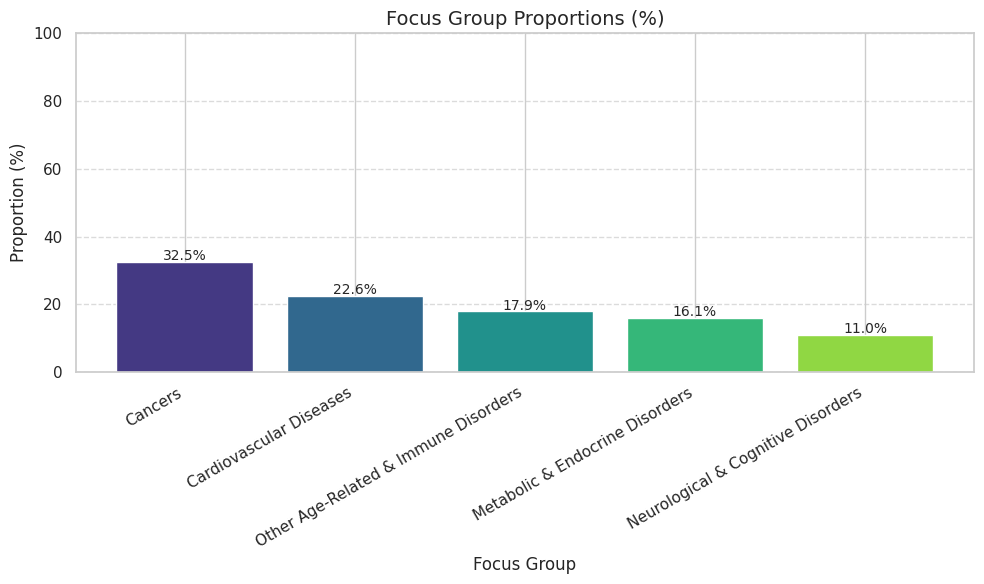

In [ ]:
# Calculate the proportions of the focus groups
focus_group_proportions = df['focus_group'].value_counts(normalize=True) * 100

# Get colors from a suitable palette
colors = sns.color_palette('viridis', len(focus_group_proportions))

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(focus_group_proportions.index, focus_group_proportions, color=colors)

# Write percentages above the bars
for bar, percentage in zip(bars, focus_group_proportions):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', fontsize=10)

# Graph settings
plt.title('Focus Group Proportions (%)', fontsize=14)
plt.xlabel('Focus Group', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100) # Set y-axis limit to 100
plt.tight_layout()
plt.show()

Looking at the counts and proportions of the focus groups after dropping the rows with missing focus_group values, we can observe the distribution of the remaining data:

- **Cancers** is the largest focus group with 210 entries, making up the highest proportion of the dataset.
- **Cardiovascular Diseases** is the second largest group with 146 entries.
- **Other Age-Related & Immune Disorders** follows with 116 entries.
- **Metabolic & Endocrine Disorders** has 104 entries.
- **Neurological & Cognitive Disorders** is the smallest group with 71 entries.

The bar chart visualizing the proportions clearly shows this imbalance. The 'Cancers' group accounts for a significant portion, while 'Neurological & Cognitive Disorders' is the least represented. This class imbalance is important to keep in mind when evaluating model performance, as models can sometimes perform better on classes with more training examples. **Stratification** we'll make during the train-test split will help ensure that this distribution is maintained in both sets, providing a more realistic evaluation of how the model performs on each class.

---

**Answer**

Let's calculate descriptive statistics for the text lengths in the ``answer`` column, which will serve as the training texts.


In [ ]:
df["answer_char_lenght"] = df["answer"].apply(lambda x: len(x))
df["answer_word_count"] = df["answer"].apply(lambda x: len(x.split()))

answer_length_stats = df[["answer_char_lenght","answer_word_count"]].describe()
answer_length_stats

,answer_char_lenght,answer_word_count
count,647.000000,647.000000
mean,2084.395672,330.584235
std,2736.381687,418.234941
min,87.000000,10.000000
25%,458.500000,75.000000
50%,1066.000000,171.000000
75%,2598.000000,423.500000
max,29046.000000,4281.000000


According to our statistics, the length of the response texts varies considerably. On average, responses are around 330 words and 2084 characters. However, while the shortest response is 10 words, the longest can be up to 4281 words. This wide range reveals the varying levels of detail in the responses in the dataset, and some responses are quite comprehensive.

**Preference for Word-Based Token Generation Over Character-Based Token Generation**

Considering one of the project's goals and analysis questions: ``"Would it be more useful to generate one character or word at a time?"``, these text length statistics provide us with an important clue. The fact that the average word count (330) of the responses is much lower than the character count (2084) suggests that a word-based approach would be more efficient.

Word-based token generation generally conveys more semantic meaning than character-based token generation and helps the model better understand the context of the text. Furthermore, word-based tokenization, especially in longer texts, requires significantly fewer tokens than character-based tokenization. This speeds up model training and enables more efficient use of computational resources.

For these reasons, considering the average and maximum lengths of the response texts, word or word fragment-based token generation would be a more useful and effective method than character-based token generation, as it better captures semantic integrity and reduces processing overhead.

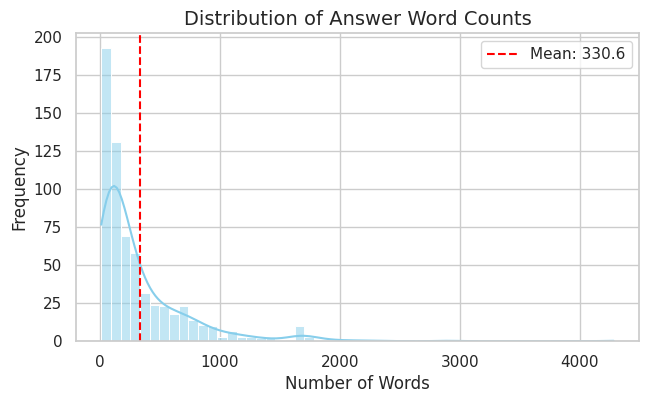

In [ ]:
# Visualize the distribution of word counts
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['answer_word_count'], kde=True, color='skyblue')
plt.title('Distribution of Answer Word Counts', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=answer_length_stats['answer_word_count']['mean'],
            color='red', linestyle='--', label=f"Mean: {answer_length_stats['answer_word_count']['mean']:.1f}")
plt.legend()
plt.show()

The histogram shows that the distribution of word counts in the responses is skewed to the right. This indicates that most responses are short or medium in length, but there are a few very long responses. The fact that the mean (330 words) is to the right of the peak further emphasizes this skew and the impact of long responses. We might consider dropping texts with notably low or high word counts (outliers).

---

## Text Cleaning and Pre-Processing

Next, we'll need to clean and pre-process the texts in the answer column and the target labels in the focus_group column.


**Encode Target Focus Groups**

In [ ]:
focus_map = {"Neurological & Cognitive Disorders":0,
             "Cancers":1,
             "Cardiovascular Diseases":2,
             "Metabolic & Endocrine Disorders":3,
             "Other Age-Related & Immune Disorders":4}


df["focus_group"] = df["focus_group"].map(focus_map)

df.head()

,question,answer,source,focus_area,focus_group,answer_char_lenght,answer_word_count
14,What is (are) High Blood Pressure ?,High blood pressure is a common disease in whi...,NIHSeniorHealth,High Blood Pressure,2,5586,940
15,What causes High Blood Pressure ?,Changes in Body Functions Researchers continue...,NIHSeniorHealth,High Blood Pressure,2,3455,498
16,Who is at risk for High Blood Pressure? ?,Not a Normal Part of Aging Nearly 1 in 3 Ameri...,NIHSeniorHealth,High Blood Pressure,2,2421,404
17,How to prevent High Blood Pressure ?,Steps You Can Take You can take steps to preve...,NIHSeniorHealth,High Blood Pressure,2,6606,1158
18,What are the symptoms of High Blood Pressure ?,"High blood pressure is often called the ""silen...",NIHSeniorHealth,High Blood Pressure,2,8183,1384


**Drop Duplicate Rows**

We've noticed that many of the text in the answer column are duplicates (or fairly similar), which is common among medical texts.

We'll need to drop duplicates, otherwise:

- the model will overfit to over-represented texts
- the model will have more trouble generalizing to unseen texts
- model training will take longer

In [ ]:
df.drop_duplicates(subset="answer",inplace=True)
df.shape

(624, 7)

**Split the Data into Training and Testing Sets**

Let's split the dataset into 80% training and 20% testing.

Since our dataset is fairly small (considering that we only used the top 25 most occurring focus areas), we'll need to stratify the distribution of focus groups to ensure fair representation in the training and testing sets.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["focus_group"])

print("Training set distribution:", train_df['focus_group'].value_counts(1))
print("Testing set distribution:", test_df['focus_group'].value_counts(1))

Training set distribution: focus_group
1    0.334669
2    0.234469
4    0.186373
3    0.130261
0    0.114228
Name: proportion, dtype: float64
Testing set distribution: focus_group
1    0.336
2    0.232
4    0.184
3    0.136
0    0.112
Name: proportion, dtype: float64


**Create Training Corpus**

Next, let's create the training corpus by converting each text sequence and focus group labels to lists:

- ``train_texts`` will contain each answer text separated by commas
- ``train_labels`` will contain each focus group label separated by commas

In [ ]:
train_texts = train_df["answer"].tolist()
train_labels = train_df["focus_group"].tolist()

# Print the first two training texts and labels
print(train_texts[0:2])
print(train_labels[0:2])

["Diabetic retinopathy often has no early warning signs. Don't wait for symptoms. Be sure to have a comprehensive dilated eye exam at least once a year.  Learn more about a comprehensive dilated eye exam.", 'Breast cancer affects one in eight women during their lives. Breast cancer kills more women in the United States than any cancer except lung cancer. No one knows why some women get breast cancer, but there are a number of risk factors. Risks that you cannot change include       - Age - the chance of getting breast cancer rises as a woman gets older     - Genes - there are two genes, BRCA1 and BRCA2, that greatly increase the risk. Women who have family members with breast or ovarian cancer may wish to be tested.     - Personal factors - beginning periods before age 12 or going through menopause after age 55       Other risks include being overweight, using hormone replacement therapy (also called menopausal hormone therapy), taking birth control pills, drinking alcohol, not having 

**Remove Keywords from Training Text**

One issue we might encounter is that the training text might contain the actual focus group label, which may cause data leakage. Our model could cheat by detecting keywords and memorizing the focus group label instead of actually learning the patterns and relationships within the medical text.

One strategy is to remove keywords from the training text:

In [ ]:
remove_keywords = [
    'Breast Cancer', 'Prostate Cancer', 'Skin Cancer',
    'Colorectal Cancer', 'Lung Cancer', 'Leukemia', 'Stroke', 'Heart Failure', 'Heart Attack',
    'High Blood Cholesterol', 'High Blood Pressure', 'Causes of Diabetes', 'Diabetes', 'Diabetic Retinopathy',
    'Hemochromatosis', 'Kidney Disease', 'Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Balance Problems',
    'Shingles', 'Osteoporosis', 'Age-related Macular Degeneration',
    'Psoriasis', 'Gum (Periodontal) Disease', 'Dry Mouth'
]

# Split all multi-word phrases into individual words
# Ex. "High Blood Cholesterol" ==> "High", "Blood", "Cholesterol"
words_to_remove = set()
for phrase in remove_keywords:
    for word in re.findall(r'\b\w+\b', phrase):
        words_to_remove.add(word.lower())  # lowercased for case-insensitive match

# Create regex pattern to match any of the words
pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, words_to_remove)) + r')\b', flags=re.IGNORECASE)

# Remove individual words from each text
masked_train_texts = [pattern.sub('', text) for text in train_texts]

# Normalize whitespace
masked_train_texts = [re.sub(r'\s+', ' ', text).strip() for text in masked_train_texts]

**Tokenize the Training Text**

Next, we'll tokenize each training text into word tokens.

In [ ]:
def tokenize(text):
  tokenized_text = re.findall(r'\b\w+\b',text.lower())
  return tokenized_text

tokenized_training_corpus = [tokenize(text) for text in masked_train_texts]

# Print the first tokenized text sequence
print(tokenized_training_corpus[0])

['often', 'has', 'no', 'early', 'warning', 'signs', 'don', 't', 'wait', 'for', 'symptoms', 'be', 'sure', 'to', 'have', 'a', 'comprehensive', 'dilated', 'eye', 'exam', 'at', 'least', 'once', 'a', 'year', 'learn', 'more', 'about', 'a', 'comprehensive', 'dilated', 'eye', 'exam']


**Count the Number of Occurrences for each Word Token**

In [ ]:
combined_training_corpus = []
for text in tokenized_training_corpus:
  for token in text:
    combined_training_corpus.append(token)

word_freqs = Counter(combined_training_corpus)

**Create the Vocabulary**

We'll build the vocabulary using the top 1,000 most commonly occuring word tokens.

In [ ]:
MAX_VOCAB_SIZE = 1000
most_common_words = word_freqs.most_common(MAX_VOCAB_SIZE)
print("Top 10 most common words:",most_common_words[:10])

Top 10 most common words: [('the', 7750), ('to', 3886), ('and', 3786), ('a', 3469), ('in', 2694), ('or', 2666), ('is', 2301), ('are', 1643), ('for', 1537), ('your', 1523)]


Then, we'll create the vocabulary as a dictionary assigning each token a token ID based on its positional value and frequency counts.

We'll also create two special tokens:

- ``<unk>`` with the token ID value ``0``
- ``<pad>`` with the token ID value ``1``

In [ ]:
vocab = {word: i+2 for i, (word, freq) in enumerate(most_common_words)}
vocab["<unk>"] = 0
vocab["<pad>"] = 1

len(vocab)

1002

**Encode and Pad/Truncate the Tokenized Text**

Using the vocabulary, we'll encode the text.

While encoding the text, we'll also pad or truncate the text to a specified maximum sequence length value of 128 tokens.





In [ ]:
def encode_text(text, vocab):
  tokenized_text = tokenize(text)
  encoded_text = [vocab.get(word,vocab["<unk>"]) for word in tokenized_text]
  return encoded_text

def pad_or_truncate(encoded_text, max_length):
  if len(encoded_text) > max_length:
    return encoded_text[:max_length]
  else:
    return encoded_text + [vocab["<pad>"]] * (max_length - len(encoded_text))

In [ ]:
MAX_SEQ_LENGTH = 128

padded_train_seqs = [pad_or_truncate(encode_text(text, vocab), MAX_SEQ_LENGTH) for text in train_texts]

**Convert to PyTorch Tensors**

Next, we'll convert the encoded, tokenized text into PyTorch tensors for training.

In [ ]:
X_train_tensor = torch.tensor(padded_train_seqs)
y_train_tensor = torch.tensor(train_labels,dtype=torch.long)

We'll also organize the training tensors into training batches.

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

**Pre-Process the Testing Set**

Now we will do all the pre-processing steps for the test set we did for the training set.

In [ ]:
# Convert the testing texts and labels to lists
test_texts = test_df['answer'].tolist()
test_labels = test_df['focus_group'].tolist()

# Encode and pad/truncate the testing sequences
padded_test_seqs = [pad_or_truncate(encode_text(seq, vocab), MAX_SEQ_LENGTH) for seq in test_texts]

# Convert testing sequences to tensors
X_tensor_test = torch.tensor(padded_test_seqs)
y_tensor_test = torch.tensor(test_labels, dtype=torch.long)

# Batch the testing set
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

---

## Text Classification Models

### Simple Neural Network

The first text classification model we'll build is a simple neural network with an embedding layer that will serve as a baseline model.

**Build NN Architecture**

In [ ]:
class SimpleNNWithEmbedding(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, output_size):
    super(SimpleNNWithEmbedding, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.fc1 = nn.Linear(embed_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size,output_size)

  def forward(self,x):
    x = self.embedding(x)
    x = torch.mean(x,dim=1)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    return x

**Instantiate the Model**

In [ ]:
vocab_size = len(vocab)
embed_size = 50
hidden_size = 100
output_size = n_focus_groups

text_classifier = SimpleNNWithEmbedding(vocab_size, embed_size, hidden_size, output_size)
print(text_classifier)

SimpleNNWithEmbedding(
  (embedding): Embedding(1002, 50)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)


**Specify Loss Function and Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(text_classifier.parameters(), lr=0.0001)

**Model Training**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 100 == 0:
            print(f"[Epoch {epoch + 1}/{num_epochs}], Average CE Loss: {avg_loss:.10f}")

# Train the model
train_model(text_classifier, train_dataloader, criterion, optimizer, num_epochs=500)

[Epoch 100/500], Average CE Loss: 1.0998785477
[Epoch 200/500], Average CE Loss: 0.6455434198
[Epoch 300/500], Average CE Loss: 0.3275533072
[Epoch 400/500], Average CE Loss: 0.1499232915
[Epoch 500/500], Average CE Loss: 0.0699038330


#### **Model Evaluation**

Next, we'll evaluate the simple neural network on the testing set.

**Generate Testing Set Predictions**

In [ ]:
def get_predictions_and_probabilities(model, test_loader):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            predicted_labels = torch.argmax(outputs, dim=1)
            all_labels.extend(predicted_labels.cpu().numpy())

    return all_probs, all_labels

# Generate predictions
pred_probs, pred_labels = get_predictions_and_probabilities(text_classifier, test_loader)

**Evaluate the Neural Network**

In [ ]:
focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases",
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

report = classification_report(test_labels, pred_labels, target_names=focus_group_names)
print(report)

                                      precision    recall  f1-score   support

  Neurological & Cognitive Disorders       0.93      1.00      0.97        14
                             Cancers       0.89      0.98      0.93        42
             Cardiovascular Diseases       0.79      0.79      0.79        29
     Metabolic & Endocrine Disorders       0.75      0.71      0.73        17
Other Age-Related & Immune Disorders       0.95      0.78      0.86        23

                            accuracy                           0.86       125
                           macro avg       0.86      0.85      0.85       125
                        weighted avg       0.86      0.86      0.86       125



Nice, the simple neural network looks fairly decent, with an overall accuracy of 86%!

Let's break down the performance for each class:

- **Neurological & Cognitive Disorders:** Despite having the fewest examples (14) in the test set, the model performed exceptionally well. Precision was high (few false positives) and Recall was 100% (it correctly identified all texts belonging to this class). It is one of the highest-performing classes with an F1-score of 0.97.
- **Cancers:** This is the largest class in the test set with 42 examples. The model also performed very well here. Precision was high (few false positives) and Recall was nearly perfect at 98%. It also has a strong F1-score of 0.93.
- **Cardiovascular Diseases:** For this class with 29 examples, Precision and Recall values ​​are around 79% and balanced. The F1-score is average at 0.79. This is an area with potential for improvement.
- **Metabolic & Endocrine Disorders:** This is one of the smaller classes in the test set with 17 examples. Precision is 75% (with some false positives), but Recall is significantly lower at 71%. This indicates that the model failed to correctly identify approximately one-third of the texts belonging to this class. The F1-score is the lowest-performing class at 0.73.
- **Other Age-Related & Immune Disorders:** For this class with 23 examples, Precision is very high at 95% (very few false positives), but Recall is lower at 78%. The F1-score is 0.86, demonstrating good overall performance.

Overall, we achieved surprisingly good results for our simple neural network baseline model. The high performance in the ``"Neurological & Cognitive Disorders"`` class, despite its small number of examples, is particularly noteworthy. However, the low Recall value in the ``"Metabolic & Endocrine Disorders"`` class suggests that the model struggles to distinguish texts on this topic. This is one of the main areas where the model could be improved. Perhaps collecting more training data for this class or applying data balancing techniques would be beneficial.

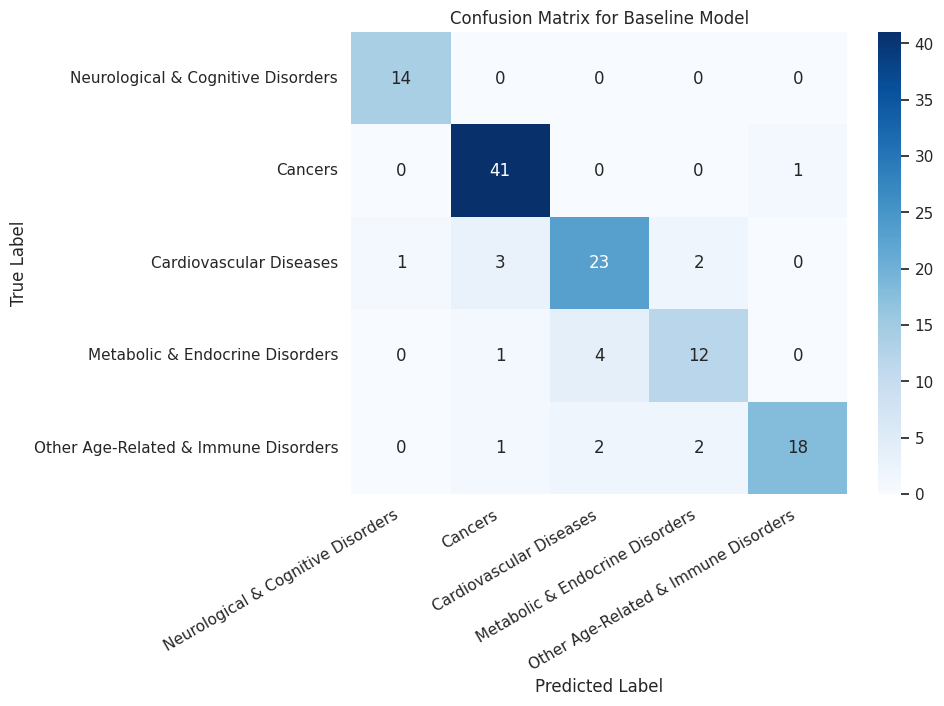

In [ ]:
matrix = confusion_matrix(test_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=focus_group_names, yticklabels=focus_group_names)
plt.title('Confusion Matrix for Baseline Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=30,ha="right")
plt.show()

When we look at the confusion matrix;

- **Neurological & Cognitive Disorders:** All 14 samples that actually belong to this class were correctly predicted. The model performed very well in this class.
- **Cancers:** 41 of the 42 samples that actually belong to this class were correctly predicted. Only 1 sample was misclassified. Performance is very high for this class.
- **Cardiovascular Diseases:** 23 of the 29 samples that actually belong to this class were correctly predicted. 3 samples were misclassified as "Cancers" and 3 as "Other Age-Related & Immune Disorders."
- **Metabolic & Endocrine Disorders:** 12 of the 17 samples that actually belong to this class were correctly predicted. 2 samples were misclassified as "Cancers," 1 as "Cardiovascular Diseases," 1 as "Neurological & Cognitive Disorders," and 1 as "Other Age-Related & Immune Disorders." This class is one of the classes where the model makes the most errors.
- **Other Age-Related & Immune Disorders:** 18 of the 23 examples belonging to this class were correctly predicted. One example was misclassified as "Cancers," two as "Cardiovascular Diseases," and two as "Metabolic & Endocrine Disorders."

This matrix visually supports the results in the classification report. In the ``"Metabolic & Endocrine Disorders"`` class, in particular, we can clearly see that the model confused text belonging to this class with other classes. This explains the lower Recall value for that class.

---

### Fine-Tune a BERT Transformer

Let's now train a more advanced BERT transformer!

We'll use a specialized BERT called [BiomedBERT](https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext) from HuggingFace that has been pre-trained on medical texts like abstracts and full articles from PubMed.

**Load a Pre-Trained BERT**

In [ ]:
# Load BiomedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_focus_groups)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Move to GPU**

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
bert_model = bert_model.to(device)

Using device: cuda


**Freeze and Unfreeze Layers**

Next, we'll freeze and unfreeze specific layers in the BiomedBERT:

1. Initial freezing of all layers
2. Unfreeze the classification head
3. Unfreeze the last 3 transformer layers
4. Unfreeze the pooler layer

In [ ]:
# Freeze all parameters first
for param in bert_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in bert_model.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last 3 layers of the encoder (layers 9-11)
for i in range(9, 12):
    for param in bert_model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

# Unfreeze the pooler (connecting the BERT output to the classification head)
for param in bert_model.bert.pooler.parameters():
    param.requires_grad = True

**Pre-Process the Training/Testing Texts for BiomedBERT**

1. Set a maximum sequence length of 512 tokens (standard for BiomedBERT)
2. Tokenize the texts
3. Convert texts and labels into tensors
4. Load the data into batches

Note: We'll use the same masked training set (with the focus group labels removed from the ``answer`` texts) to train the simple neural network.

In [ ]:
# Pre-process training text
MAX_SEQ_LENGTH = 512

X_train = bert_tokenizer(masked_train_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_train = torch.tensor(train_labels, dtype=torch.long)

train_dataset = TensorDataset(
    X_train['input_ids'].to(device),
    X_train['attention_mask'].to(device),
    y_train.to(device)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
# Pre-process testing text
X_test = bert_tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=MAX_SEQ_LENGTH)
y_test = torch.tensor(test_labels, dtype=torch.long)

test_dataset = TensorDataset(X_test['input_ids'].to(device),
                             X_test['attention_mask'].to(device),
                             y_test.to(device))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

**Specify Loss Function and Optimizer**

In [ ]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, bert_model.parameters()),
                              lr=0.00001)
criterion = nn.CrossEntropyLoss()

**Fine-Tuning Loop**

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    bert_model.train()
    total_loss = 0.0

    for batch_X, batch_attention_mask, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = bert_model(input_ids=batch_X, attention_mask=batch_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, batch_y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Average CE Loss: {avg_loss}')

Epoch [1/10] - Average CE Loss: 1.5789377093315125
Epoch [2/10] - Average CE Loss: 1.467563696205616
Epoch [3/10] - Average CE Loss: 1.316890113055706
Epoch [4/10] - Average CE Loss: 1.074480552226305
Epoch [5/10] - Average CE Loss: 0.7633295934647322
Epoch [6/10] - Average CE Loss: 0.5114924153313041
Epoch [7/10] - Average CE Loss: 0.35926617961376905
Epoch [8/10] - Average CE Loss: 0.2561222342774272
Epoch [9/10] - Average CE Loss: 0.19066145434044302
Epoch [10/10] - Average CE Loss: 0.16464075807016343


#### **Model Evaluation**

Lastly, let's evaluate the fine-tuned BiomedBERT and compare its performance against the simple neural network baseline

**Generate Testing Set Predictions**

In [ ]:
bert_model.eval()
bert_pred_probs = []
bert_pred_labels = []

with torch.no_grad():
    for batch_X, batch_attention_mask, batch_y in test_loader:
        outputs = bert_model(input_ids= batch_X,
                                   attention_mask= batch_attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        bert_pred_probs.extend(probs.cpu().numpy())

        predicted_labels = torch.argmax(logits, dim=1)
        bert_pred_labels.extend(predicted_labels.cpu().numpy())

**Evaluate the Fine-Tuned BiomedBERT**



In [ ]:
focus_group_names = ["Neurological & Cognitive Disorders", "Cancers", "Cardiovascular Diseases",
                     "Metabolic & Endocrine Disorders", "Other Age-Related & Immune Disorders"]

report = classification_report(test_labels, bert_pred_labels, target_names=focus_group_names)

print(report)

                                      precision    recall  f1-score   support

  Neurological & Cognitive Disorders       1.00      1.00      1.00        14
                             Cancers       1.00      0.98      0.99        42
             Cardiovascular Diseases       0.97      1.00      0.98        29
     Metabolic & Endocrine Disorders       1.00      0.94      0.97        17
Other Age-Related & Immune Disorders       0.96      1.00      0.98        23

                            accuracy                           0.98       125
                           macro avg       0.98      0.98      0.98       125
                        weighted avg       0.98      0.98      0.98       125



Amazingly, the fine-tuned specialized BiomedBERT significantly outperforms the simple neural network, achieving nearly perfect classification scores across all classes in each key metric!

Now, let's break down the performance for each class:

- **Neurological & Cognitive Disorders:** perfectly classified the text into this focus group
- **Cancers:** perfect precision, near perfect recall
- **Cardiovascular Diseases:** near perfect precision, perfect recall
- **Metabolic & Endocrine Disorders:** perfect precision, high recall score (remember, the simple neural network had a recall score of 71% for this under-represented class!)
- **Other Age-Related & Immune Disorders:** high precision, perfect recall

The specialized BiomedBERT does a near-perfect job of classifying medical texts into the five focus groups. There are many things to consider as to why BiomedBERT performs much better than the simple neural network:

- BiomedBERT is pre-trained on biomedical literature from PubMed and already has a strong foundational understanding of medical terminology and context
- BiomedBERT has a much more complex architecture with attention mechanisms that allow it to better capture meaningful patterns and relationships within the training text

The specialized BiomedBERT is the superior model for our medical text classification task


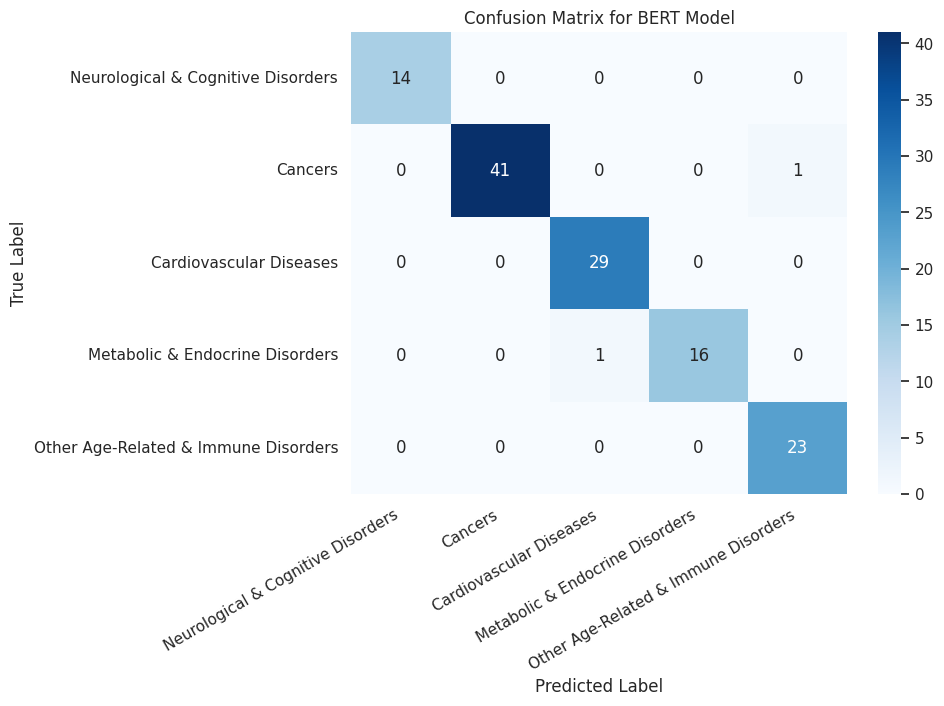

In [ ]:
matrix = confusion_matrix(test_labels, bert_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=focus_group_names, yticklabels=focus_group_names)
plt.title('Confusion Matrix for BERT Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=30,ha="right")
plt.show()

When we look at the confusion matrix for the fine-tuned BERT model:

- **Neurological & Cognitive Disorders:** All 14 samples that actually belong to this class were correctly predicted. This is a perfect performance for this class.
- **Cancers:** 41 of the 42 samples were correctly predicted, with only 1 sample being misclassified. This shows excellent performance.
- **Cardiovascular Diseases:** All 29 samples were correctly predicted. This is another perfect performance for this class.
- **Metabolic & Endocrine Disorders:** 16 of the 17 samples were correctly predicted, with only 1 sample being misclassified. This is a significant improvement compared to the simple neural network and shows very strong performance.
- **Other Age-Related & Immune Disorders:** All 23 samples were correctly predicted. This is perfect performance for this class.

The confusion matrix clearly demonstrates the superior performance of the fine-tuned specialized BiomedBERT model. It made very few errors across all classes, correctly classifying almost all the test samples. This visual representation strongly supports the high precision, recall, and F1-scores observed in the classification report. The model's ability to correctly classify instances from the "Metabolic & Endocrine Disorders" class, which was a challenge for the baseline model, is particularly noteworthy.

**Example Prediction**

Let's build a quick function that classifies an example text using the fine-tuned BiomedBERT.

In [ ]:
def biomedbert_classify_text(text):
    """
    Function that classifies a medical text (str) into 5 focus groups:
        - "Neurological & Cognitive Disorders"
        - "Cancers"
        - "Cardiovascular Diseases"
        - "Metabolic & Endocrine Disorders"
        - "Other Age-Related & Immune Disorders"
    """
    # Pre-Process and Tokenize the Text
    MAX_SEQ_LENGTH = 512
    tokenized_text = bert_tokenizer(
        example_text,
        padding='max_length',
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="pt"
    )

    # Move tokenized text to device
    tokenized_text = {k: v.to(device) for k, v in tokenized_text.items()}

    # Generate prediction
    with torch.no_grad():
        outputs = bert_model(
            input_ids=tokenized_text['input_ids'],
            attention_mask=tokenized_text['attention_mask']
        )
        predicted_label = torch.argmax(outputs.logits, dim=1)

    # Encode predicted output (int) to focus group label (str)
    reverse_focus_map = {0:"Neurological & Cognitive Disorders",
                         1:"Cancers",
                         2:"Cardiovascular Diseases",
                         3:"Metabolic & Endocrine Disorders",
                         4:"Other Age-Related & Immune Disorders"
                }
    predicted_focus = reverse_focus_map[predicted_label.cpu().item()]
    return predicted_focus

**Classify Example Text**

In [ ]:
example_text = '''The patient displays progressive deterioration of cognitive abilities affecting memory, thinking, language, and judgment. Family members report personality changes and difficulty with daily activities.
Imaging studies show cortical atrophy and enlarged ventricles. Laboratory tests rule out vitamin deficiencies, thyroid disorders, and other reversible causes of cognitive decline.
Treatment focuses on symptom management and maintaining quality of life through cholinesterase inhibitors and environmental modifications.'''

biomedbert_classify_text(example_text)

'Neurological & Cognitive Disorders'

---

## Conclusion

In this project, we explored building deep learning models using PyTorch to classify medical text related to health topics from the MedQuAD dataset into five broader focus groups: Cancers, Cardiovascular Diseases, Metabolic and Endocrine Disorders, Neurological and Cognitive Disorders, and Other Age-Related and Immune Disorders.

After loading and exploring the dataset, we performed necessary data cleaning and pre-processing steps, including handling missing values, grouping the top 25 most frequent focus areas into 5 categories, encoding the target labels, dropping duplicate entries based on the 'answer' column, and splitting the data into training and testing sets while ensuring stratified distribution of focus groups.

We then built and evaluated two models:

1.  **Simple Neural Network with Embedding:** This model served as our baseline. After tokenizing, encoding, and padding the text data, we trained a simple neural network. While achieving a decent overall accuracy of 86%, the model showed varying performance across classes, particularly struggling with the "Metabolic & Endocrine Disorders" class (71% recall), indicating confusion with other categories as seen in the confusion matrix.

2.  **Fine-Tuned BiomedBERT Transformer:** We fine-tuned a specialized BERT model pre-trained on biomedical literature. We pre-processed the data using the BiomedBERT tokenizer and trained the model on the masked training texts (with focus group labels removed). The fine-tuned BiomedBERT achieved significantly higher performance, with a near-perfect overall accuracy of 98% and excellent precision, recall, and F1-scores across all classes. The confusion matrix for the BERT model demonstrated minimal misclassifications, even for the "Metabolic & Endocrine Disorders" class, which was challenging for the baseline.

The superior performance of the specialized BiomedBERT highlights the advantage of using models pre-trained on domain-specific data and leveraging complex architectures like transformers with attention mechanisms, which are better equipped to understand the nuances and context within medical text.

The final fine-tuned BiomedBERT model is highly effective at classifying medical text into the defined focus groups based on this dataset. However, it's important to remember the limitations mentioned at the beginning of the notebook; these models are built and trained on a limited subset of data and are not intended for real-world medical applications.

---